In [1]:
import os
import re
import time
from pathlib import Path
import shutil
import glob
import string
import unicodedata
from datetime import datetime, timedelta

import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.select import Select
from sqlalchemy import create_engine
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

from unicodedata import normalize, category

In [100]:
def clean_text_1(_text):
    """
        Ll : minusculas
        Zs : espacios
        Lu : mayusculas
        Nd : numeros
        Mn : tildes
        Ps : abre dieresis, .....
        Pe : cierra dieresis, .......
        Pi : abre parentesis, .....
        Po : cierra parentesis, punto, coma, .....        
        ...
    """
    
    cleaned = ''.join(
        (_ for _ in normalize('NFD', _text.replace('.', 'ZZZ')) if category(_) in ['Ll', 'Zs', 'Lu', 'Nd'])
    )
    return re.sub(
        '\s{2,}', ' ', cleaned.replace('\n', ' ').replace('.', ' ').replace(',', ' ').replace(';', ' ').replace(':', ' ')
    )

def uniform_title(_text):
    _split = _text.split()
    return ' '.join([_.title() if _ == _.upper() else _ for _ in _split])

class CleanNews(object):
    def __init__(self, hoy_format=None):
        #-------------------------- Habilitacion de ruta --------------------------#
        self.folder_news = 'news'
        if not os.path.exists(self.folder_news):
            os.makedirs(self.folder_news)
            
        self.hoy = datetime.today()
        self.hoy_format = self.hoy.strftime('%d%m%Y') if hoy_format is None else hoy_format
        
        self.newsletter_path = os.path.join(self.folder_news, self.hoy_format, 'parseado')
        if not os.path.exists(self.newsletter_path):
            os.makedirs(self.newsletter_path)
            
        self.consol_path = os.path.join(self.folder_news, self.hoy_format, 'consolidado')
        if not os.path.exists(self.consol_path):
            os.makedirs(self.consol_path)
            
        self.flg_selected = True
        self.news = None
        self.consolidado = None
        
    def get_news(self):
        dicc_data = {
            'dia': [],
            'tipo': [],
            'titulo': [],
            'contenido': [],
            'tamanio': []
        }
        
        for file in glob.iglob('news/{}/**/*.txt'.format(self.hoy_format), recursive=True):
            listado = file.replace('/', '\\').split('\\')
            print(listado)
            with open(file, encoding='UTF-8') as f:
                new = f.read()
                dicc_data['dia'].append(listado[1])
                dicc_data['tipo'].append(listado[2])
                dicc_data['titulo'].append(listado[-1].split('.')[0])
                dicc_data['contenido'].append(new)
                dicc_data['tamanio'].append(len(new.split(' ')))
                
        self.news = pd.DataFrame(dicc_data)
        return self.news
    
    def consolidacion(self):
        self.news['parseado_1'] =  self.news['contenido'].apply(lambda _: clean_text_1(_).lower())
        self.news.to_csv(
            os.path.join(self.consol_path, 'consolidado.csv'), index=False
        )
        
        return self.news
    
    def change_consolidacion(self):
        data = []
        consol = pd.read_csv(os.path.join(self.consol_path, 'consolidado.csv'))
        for row in consol.iterrows():
            #print(row[-1], type(row[-1]), len(row[-1]))
            contenido = row[-1].iloc[-1].strip().split('zzz')
            
            for orden, oracion in enumerate(contenido, start=1):
                data.append([
                    row[-1].iloc[0], row[-1].iloc[1], row[-1].iloc[2], row[-1].iloc[3], row[-1].iloc[4], row[-1].iloc[5], orden, oracion
                ])
                
            #print(contenido)
        data = pd.DataFrame(data)
        data.columns = list(self.news.columns) + ['suborden', 'oracion']
        data['len_oracion'] = data['oracion'].apply(lambda _: len(_.split()))
        data = data[data['len_oracion'] > 1]
        data.to_csv(
            os.path.join(self.consol_path, 'consolidado.csv'), index=False
        )
        return data
        

In [101]:
#from unicodedata import normalize, category
#text_nasty = "de 8:30 a.m. a 8:00 p.m."

#for _ in normalize('NFD', text_nasty):
#    print(_, category(_))
    

In [102]:
cleaner = CleanNews()
cleaner.get_news()
news = cleaner.consolidacion()
news.head()

['news', '01082021', 'descartado', 'coronavirus-bolivia-en-vivo-hoy-sabado-31-de-julio-de-2021-bolivia-registra-693-nuevos-casos-de-covid-19-y-1.txt']
['news', '01082021', 'descartado', 'coronavirus-estados-unidos-vacunados-contra-el-covid-19-pueden-tener-carga-viral-alta-tras-infectarse-con-la.txt']
['news', '01082021', 'descartado', 'coronavirus-japon-tokio-registra-por-primera-vez-mas-de-4000-casos-diarios-de-covid-19-en-medio-de-los-juego.txt']
['news', '01082021', 'descartado', 'coronavirus-sputnik-v-las-demoras-quejas-y-cancelaciones-de-la-vacuna-rusa-en-america-latina-nndc-noticia.txt']
['news', '01082021', 'descartado', 'coronavirus-usa-joe-biden-el-presidente-de-estados-unidos-anticipa-con-toda-probabilidad-nuevas-restriccione.txt']
['news', '01082021', 'descartado', 'covid-19-coronavirus-no-podran-trabajar-hacer-tramites-ni-usar-transporte-publico-las-sanciones-de-arabia-sa.txt']
['news', '01082021', 'descartado', 'covid-19-estudios-cientificos-erroneos-alimentan-la-desinform

,dia,tipo,titulo,contenido,tamanio,parseado_1
0,01082021,descartado,coronavirus-bolivia-en-vivo-hoy-sabado-31-de-j...,Bolivia registró este sábado 15 fallecidos a c...,406,bolivia registro este sabado 15 fallecidos a c...
1,01082021,descartado,coronavirus-estados-unidos-vacunados-contra-el...,En otro desalentador revés a las acciones de E...,460,en otro desalentador reves a las acciones de e...
2,01082021,descartado,coronavirus-japon-tokio-registra-por-primera-v...,"Las autoridades de la capital de Japón, Tokio,...",232,las autoridades de la capital de japon tokio h...
3,01082021,descartado,coronavirus-sputnik-v-las-demoras-quejas-y-can...,El gobierno peruano adquirió recientemente 20 ...,904,el gobierno peruano adquirio recientemente 20 ...
4,01082021,descartado,coronavirus-usa-joe-biden-el-presidente-de-est...,"El presidente de Estados Unidos, Joe Biden, ha...",264,el presidente de estados unidos joe biden ha a...


In [103]:
news.shape, news.columns

((23, 6),
 Index(['dia', 'tipo', 'titulo', 'contenido', 'tamanio', 'parseado_1'], dtype='object'))

In [104]:
consol = cleaner.change_consolidacion()
consol.head()

,dia,tipo,titulo,contenido,tamanio,parseado_1,suborden,oracion,len_oracion
0,1082021,descartado,coronavirus-bolivia-en-vivo-hoy-sabado-31-de-j...,Bolivia registró este sábado 15 fallecidos a c...,406,bolivia registro este sabado 15 fallecidos a c...,1,bolivia registro este sabado 15 fallecidos a c...,14
1,1082021,descartado,coronavirus-bolivia-en-vivo-hoy-sabado-31-de-j...,Bolivia registró este sábado 15 fallecidos a c...,406,bolivia registro este sabado 15 fallecidos a c...,2,821 las muertes acumuladas desde marzo de 2020...,21
2,1082021,descartado,coronavirus-bolivia-en-vivo-hoy-sabado-31-de-j...,Bolivia registró este sábado 15 fallecidos a c...,406,bolivia registro este sabado 15 fallecidos a c...,3,506 el total de contagios hasta el momento,8
3,1082021,descartado,coronavirus-bolivia-en-vivo-hoy-sabado-31-de-j...,Bolivia registró este sábado 15 fallecidos a c...,406,bolivia registro este sabado 15 fallecidos a c...,4,las regiones con la mayor cantidad de nuevos c...,34
4,1082021,descartado,coronavirus-bolivia-en-vivo-hoy-sabado-31-de-j...,Bolivia registró este sábado 15 fallecidos a c...,406,bolivia registro este sabado 15 fallecidos a c...,5,el ministerio de salud de bolivia tambien info...,10


<AxesSubplot:>

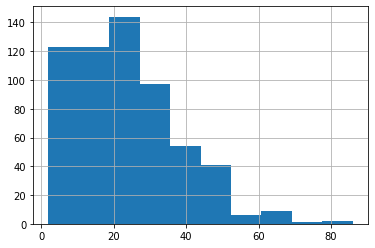

In [105]:
consol['len_oracion'].hist()

In [106]:
parseado = '.'.join(list(consol[consol['tipo'] == 'original']['oracion']))
parseado

'la pandemia de coronavirus ha dejado a muchas personas sin empleo y afecto economicamente a miles de hogares. ante ello el anterior gobierno de francisco sagasti ofrecio el bono 600 soles para que con este beneficio puedan enfrentar los retos economicos que la actual coyuntura sanitaria ha traido. aqui te alcanzamos el link oficial de consulta y todos los pasos que debes seguir para acceder a este subsidio.como se sabe el pago del bono 600 empezo en febrero de este ano y se viene entregando en fechas establecidas para que los beneficiarios puedan cobrarlo sin riesgo de contagiarse de covid19. hace unas semanas la anterior gestion anuncio que el plazo para la entrega de este beneficio economico fue ampliado hasta el 31 de agosto de 2021.para cumplir con este fin desde el inicio de su entrega el gobierno puso en funcionamiento la plataforma httpsbono600.pe para que los ciudadanos puedan verificar si han sido seleccionados.para saber si tu hogar es beneficiario del subsidio economico del

In [107]:
path_ = os.path.join(cleaner.newsletter_path, 'metodo_1.txt')
path_

'news\\01082021\\parseado\\metodo_1.txt'

In [108]:
with open(path_, 'w+', encoding="utf-8") as file:
    file.write(parseado)